# Modeling and Simulation in Python

Starter code for the orbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [15]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Earth falling into the sun

Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Here's a solution.

In [16]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [171]:
# And an inition condition (with everything in SI units)

r_0 = 147e9 * m

init = State(x=r_0, y=0, vx=0, vy=-.000011)

,values
x,147000000000.0 meter
y,0
vx,0
vy,-1.1e-05


In [187]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=1e7 * s)

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,10000000.0 second


In [188]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    
    v= Vector(vx, vy)
    r= Vector(x,y)
    forceMag = G * m1 * m2 / r.mag**2
    direction= -r.hat()
    force = direction*forceMag
    return force

In [189]:
universal_gravitation(init, system)

<Quantity([-3.6686486e+22 -0.0000000e+00], 'newton')>

In [190]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)    
    v= Vector(vx, vy)
    r= Vector(x,y)
    force = universal_gravitation(state, system)
    dxdt=v.x
    dydt = v.y
    dvdt = force / m2
    
    return dxdt, dydt, dvdt.x, dvdt.y

In [191]:
# Always test the slope function!

slope_func(init, 0, system)

(<Quantity(0.0, 'dimensionless')>,
 <Quantity(-1.1e-05, 'dimensionless')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [192]:
# Here's an event function that stops the simulation
# before the collision

def event_func(state, t, system):
    x, y, vx, vy = state
    r= Vector(x,y)
    return r - system.r_final

In [193]:
# Always test the event function!

event_func(init, 0, system)

<Quantity([ 1.46298121e+11 -7.01879000e+08], 'meter')>

In [194]:
# Finally we can run the simulation

results, details = run_ode_solver(system, slope_func, events=event_func)
details

TypeError: only size-1 arrays can be converted to Python scalars

In [195]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(11.574074074074074, 'second')>

In [181]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(11.574074074074073, 'day')>

In [182]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

In [183]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [184]:
# Scaling the distance to million km

x = results.x / 1e9;
y=results.y /1e9;

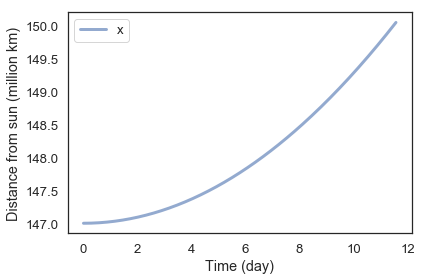

In [186]:
# And plotting

plot(x, label='x')
#plot(y,label='y')
decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')